# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized (per layer)( calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images, developing a separate NN per calo layer).
2. Simple combinations (via a new NN, or combined single deep NN) of the flattened NNs from above.
3. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
4. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [2]:
# import electron vs. pion images (pt = 100 GeV)

elec = np.load("../datasets/images_electron_100_v01-4-g1135c42.npz")
pion = np.load("../datasets/images_pion_100_v01-4-g1135c42.npz")

nelec = len(elec['EMB1'])
npion = len(pion['EMB1'])
print("Number of electron events: {}".format(nelec))
print("Number of pion events: {}".format(npion))
print("Total: {}".format(nelec+npion))

Number of electron events: 11741
Number of pion events: 10968
Total: 22709


In [2]:
# import pi+- vs. pi0 images

# seed = 10
# np.random.seed(seed)
path = '/fast_scratch/atlas_images/'
#path = '/eos/user/m/mswiatlo/images/'

# TODO fix input files so that it is easier to split up the events
p0 = np.load(path+"pi0_small.npz")
pp = np.load(path+"piplus_small.npz")
pm = np.load(path+"piminus_small.npz")

# pc = {}
#concat pp and pm for greater stats
# pc = {key:np.append(pp[key], pm[key], 0) for key in pp}

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])
# npc = len(pc['EMB1'])


print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
# print("Number of cpi events: {}".format(npc))
print("Total: {}".format(np0+npp+npm))

# print pp['label']
# print pm['label']
# print p0['label']

Number of pi0 events: 50000
Number of pi+ events: 50000
Number of pi- events: 50000
Total: 150000


### Plot a few example images

<Figure size 432x288 with 0 Axes>

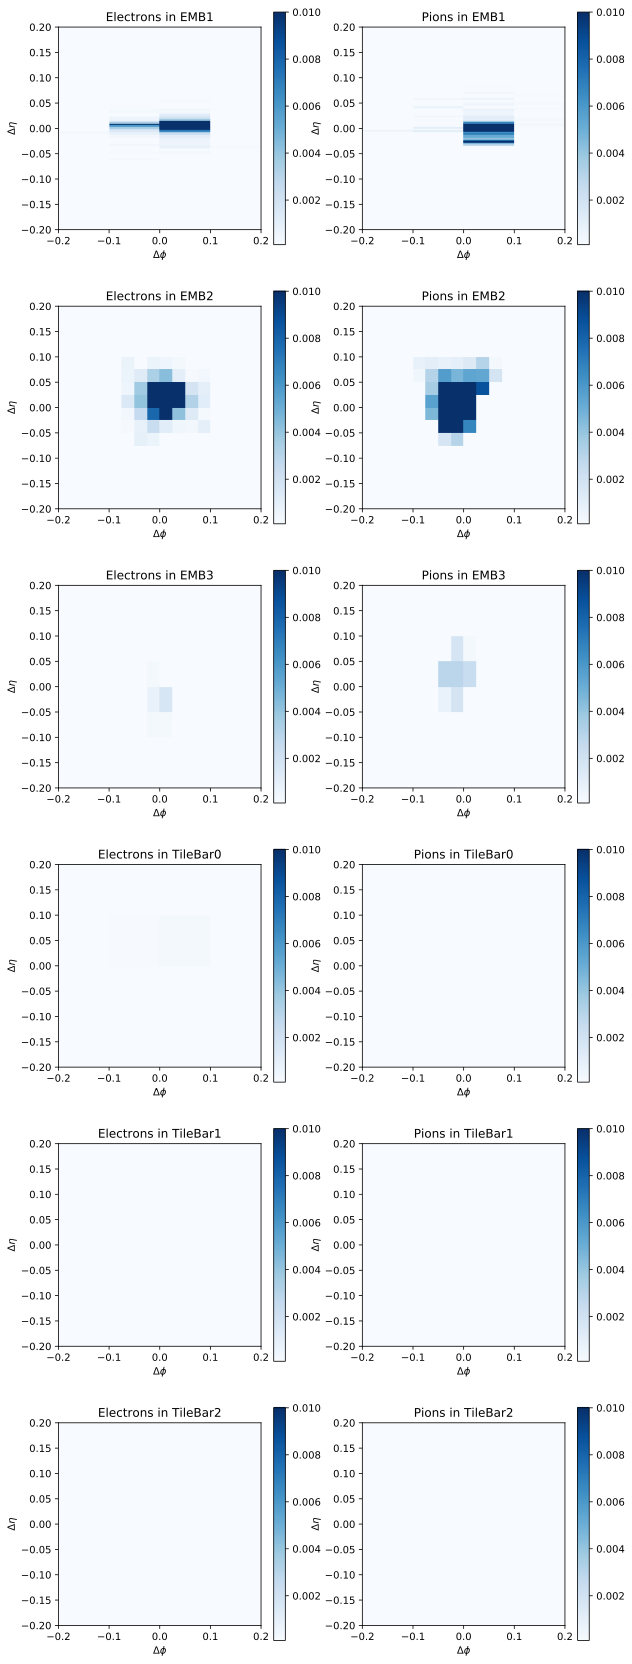

In [3]:
# plots for pT = 100 GeV electron/pion samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 10

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,30))
fig.patch.set_facecolor('white')


i = 1
for layer in layers:
    
    # electrons
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(elec[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Electrons in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")
    
    # all(?) pions
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(pion[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Pions in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()
#plt.savefig('plots_pion_electron.pdf')

<Figure size 432x288 with 0 Axes>

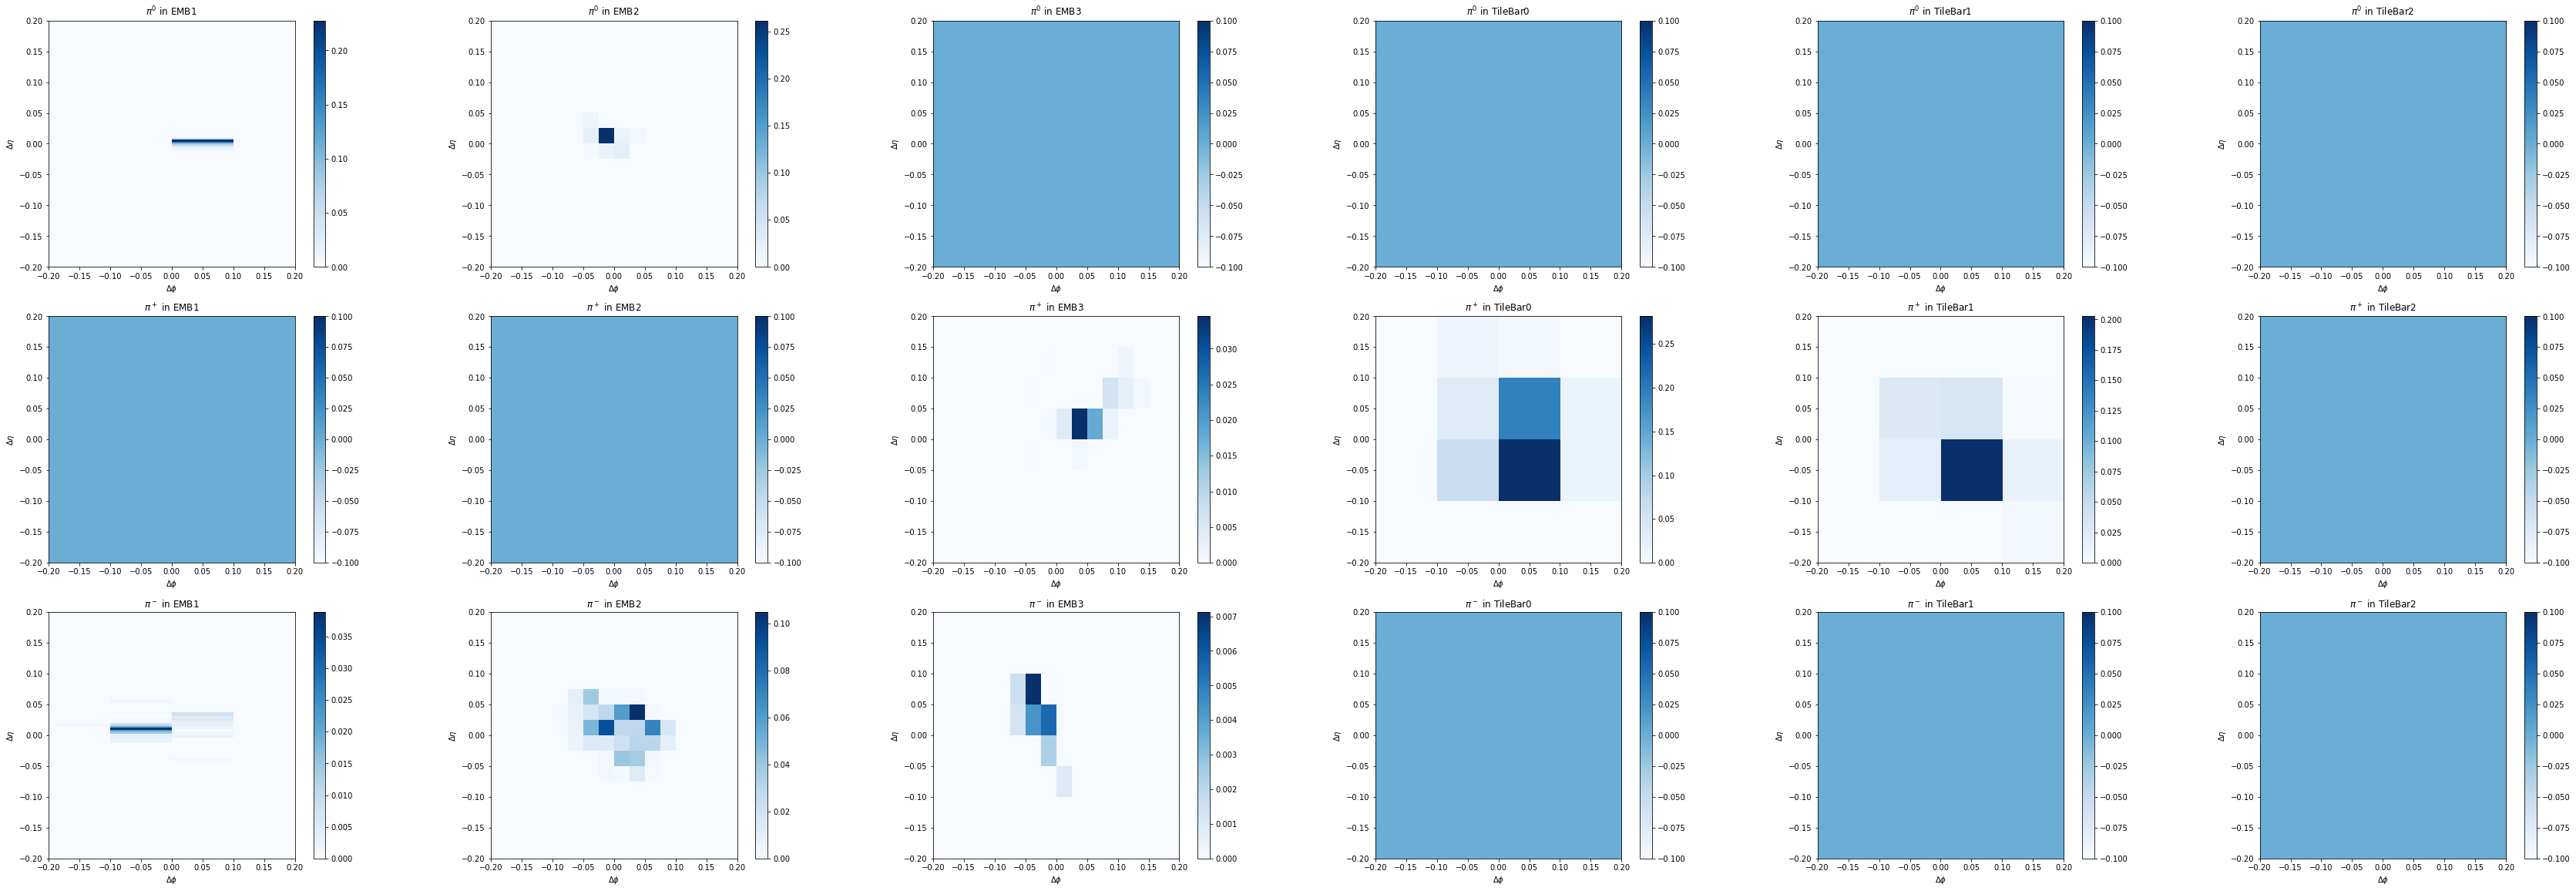

In [3]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi+
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi-
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.savefig('Plots/plots_pi0_plus_minus.pdf')
plt.show()


### Plot a few histograms

NameError: name 'pion' is not defined

<Figure size 432x288 with 0 Axes>

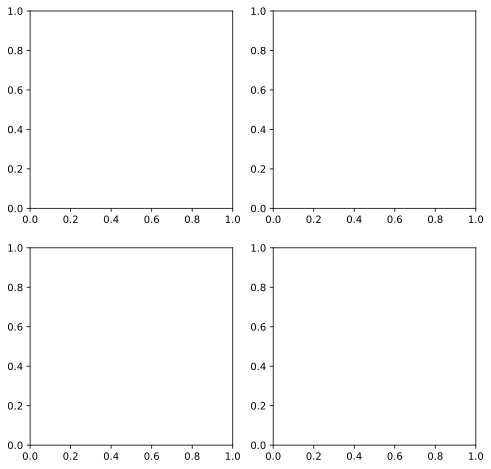

In [86]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: Mat

<Figure size 432x288 with 0 Axes>

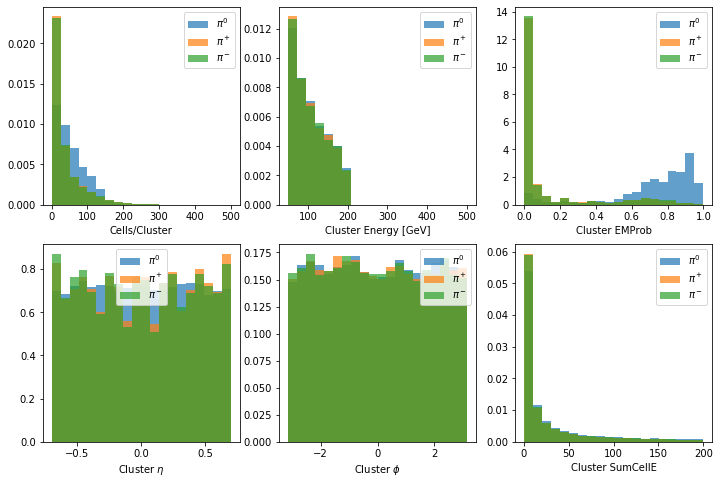

In [4]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
# ax[0,0].hist(pc['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,0].set_xlabel('Cells/Cluster')
# ax[0,0].text(0.6,0.5,'ATLAS Internal',transform=ax[0,0].transAxes)
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^-$')
# ax[0,1].hist(pc['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,0].hist(pc['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

# cluster EM prob
ax[0,2].hist(p0['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[0,2].hist(pp['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[0,2].hist(pm['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[0,2].set_xlabel('Cluster EMProb')
ax[0,2].legend()

# cluster sum cell e
ax[1,2].hist(p0['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,2].hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,2].hist(pm['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,2].set_xlabel('Cluster SumCellE')
ax[1,2].legend()

plt.savefig('Plots/hist_pi0_plus_minus.pdf')
plt.show()


## 1. Simple feed-forward Neural Network

In [5]:
# # Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# here, define a function to flatten inputs
def format_flat(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

    X = np.append(data_0[layer].reshape((len(data_0[layer]),num_pixels)),
                  data_1[layer].reshape((len(data_1[layer]),num_pixels)), axis=0)

    y = np.append(data_0['label'], data_1['label'], axis=0)

    print (X.shape)
    print (y.shape)
    return X, y, num_pixels

In [6]:
x_flat = {}
y_flat = {}
num_pixels_flat = {}
for layer_i, layer_name in enumerate(layers):
    x_flat[layer_i], y_flat[layer_i], num_pixels_flat[layer_i] = format_flat(p0, pp, layer_i)

(100000, 512)
(100000, 1)
(100000, 256)
(100000, 1)
(100000, 128)
(100000, 1)
(100000, 16)
(100000, 1)
(100000, 16)
(100000, 1)
(100000, 8)
(100000, 1)


In [7]:
#split up data into separate training, validation, and testing

test_size = 20000
validation_size = 5000
from sklearn.model_selection import train_test_split
def make_split_samples(X, y, test_size, validation_size):
    X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
    X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

    # normalize inputs from 0-255 to 0-1
    # this seems to be done already??
#     X_tr = X_tr / 255
#     X_te = X_te / 255
#     X_vl = X_vl / 255

    # one hot encode outputs
    from keras.utils import np_utils
    y_tr_onehot = np_utils.to_categorical(y_tr, 2)
    y_te_onehot = np_utils.to_categorical(y_te, 2)
    y_vl_onehot = np_utils.to_categorical(y_vl, 2)
    num_classes = y_te_onehot.shape[1]
    print("y_train.shape: ",y_tr.shape)
    print("y_train_onehot.shape: ",y_tr_onehot.shape)
    
    return X_tr, X_te, X_vl, y_tr_onehot, y_te_onehot, y_vl_onehot

In [8]:
x_flat_tr = {}
x_flat_te = {}
x_flat_vl = {}
y_flat_tr_onehot = {}
y_flat_te_onehot = {}
y_flat_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_flat_tr[layer_i], x_flat_te[layer_i], x_flat_vl[layer_i], y_flat_tr_onehot[layer_i], y_flat_te_onehot[layer_i], y_flat_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

Using TensorFlow backend.


y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)


In [39]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense

# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    model = Sequential()
    used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
    model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(used_pixels, activation='relu'))
    model.add(Dense(int(used_pixels/2), activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    optimizer = Adam(lr=5e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [14]:
# build the model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    models_flat[layer_i] = baseline_nn_model(num_pixels_flat[layer_i])
    models_flat[layer_i].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 514       
Total params: 657,154
Trainable params: 657,154
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               65792     
__________________________

In [18]:
from keras.callbacks import EarlyStopping

# now automated with functions
history_flat = {}
scores = {}
# es = EarlyStopping(monitor='val_acc', mode='max')
for layer_i, layer_name in enumerate(layers):
    print('On layer %s' % (layer_name))
    history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 100, batch_size = 200, verbose = 2)
    scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)
    print("Layer %s Baseline Error: %2d" % (layer_name, 100-scores[layer_i][1]*100))

On layer EMB1

Train on 75000 samples, validate on 5000 samples
Epoch 1/100
 - 4s - loss: 0.5928 - accuracy: 0.7898 - val_loss: 0.4724 - val_accuracy: 0.8454
Epoch 2/100
 - 2s - loss: 0.4220 - accuracy: 0.8419 - val_loss: 0.3919 - val_accuracy: 0.8510
Epoch 3/100
 - 2s - loss: 0.3968 - accuracy: 0.8456 - val_loss: 0.3849 - val_accuracy: 0.8552
Epoch 4/100
 - 2s - loss: 0.3922 - accuracy: 0.8482 - val_loss: 0.3799 - val_accuracy: 0.8560
Epoch 5/100
 - 2s - loss: 0.3887 - accuracy: 0.8498 - val_loss: 0.3766 - val_accuracy: 0.8556
Epoch 6/100
 - 2s - loss: 0.3854 - accuracy: 0.8514 - val_loss: 0.3724 - val_accuracy: 0.8580
Epoch 7/100
 - 2s - loss: 0.3826 - accuracy: 0.8529 - val_loss: 0.3698 - val_accuracy: 0.8586
Epoch 8/100
 - 2s - loss: 0.3803 - accuracy: 0.8542 - val_loss: 0.3674 - val_accuracy: 0.8612
Epoch 9/100
 - 2s - loss: 0.3778 - accuracy: 0.8558 - val_loss: 0.3652 - val_accuracy: 0.8624
Epoch 10/100
 - 2s - loss: 0.3761 - accuracy: 0.8570 - val_loss: 0.3628 - val_accuracy: 0.

Epoch 85/100
 - 2s - loss: 0.2743 - accuracy: 0.9000 - val_loss: 0.2990 - val_accuracy: 0.8932
Epoch 86/100
 - 2s - loss: 0.2738 - accuracy: 0.9001 - val_loss: 0.3014 - val_accuracy: 0.8930
Epoch 87/100
 - 2s - loss: 0.2724 - accuracy: 0.9009 - val_loss: 0.2987 - val_accuracy: 0.8910
Epoch 88/100
 - 2s - loss: 0.2725 - accuracy: 0.9009 - val_loss: 0.2992 - val_accuracy: 0.8902
Epoch 89/100
 - 2s - loss: 0.2714 - accuracy: 0.9013 - val_loss: 0.3030 - val_accuracy: 0.8886
Epoch 90/100
 - 2s - loss: 0.2708 - accuracy: 0.9012 - val_loss: 0.3023 - val_accuracy: 0.8930
Epoch 91/100
 - 2s - loss: 0.2708 - accuracy: 0.9015 - val_loss: 0.3056 - val_accuracy: 0.8904
Epoch 92/100
 - 2s - loss: 0.2708 - accuracy: 0.9017 - val_loss: 0.3041 - val_accuracy: 0.8920
Epoch 93/100
 - 2s - loss: 0.2686 - accuracy: 0.9021 - val_loss: 0.2985 - val_accuracy: 0.8906
Epoch 94/100
 - 2s - loss: 0.2683 - accuracy: 0.9030 - val_loss: 0.3034 - val_accuracy: 0.8918
Epoch 95/100
 - 2s - loss: 0.2686 - accuracy: 0.90

Epoch 71/100
 - 2s - loss: 0.3166 - accuracy: 0.8736 - val_loss: 0.3188 - val_accuracy: 0.8730
Epoch 72/100
 - 2s - loss: 0.3158 - accuracy: 0.8742 - val_loss: 0.3176 - val_accuracy: 0.8736
Epoch 73/100
 - 2s - loss: 0.3151 - accuracy: 0.8741 - val_loss: 0.3190 - val_accuracy: 0.8734
Epoch 74/100
 - 2s - loss: 0.3136 - accuracy: 0.8747 - val_loss: 0.3239 - val_accuracy: 0.8712
Epoch 75/100
 - 2s - loss: 0.3131 - accuracy: 0.8751 - val_loss: 0.3196 - val_accuracy: 0.8760
Epoch 76/100
 - 2s - loss: 0.3135 - accuracy: 0.8751 - val_loss: 0.3181 - val_accuracy: 0.8758
Epoch 77/100
 - 2s - loss: 0.3128 - accuracy: 0.8755 - val_loss: 0.3163 - val_accuracy: 0.8740
Epoch 78/100
 - 2s - loss: 0.3129 - accuracy: 0.8755 - val_loss: 0.3172 - val_accuracy: 0.8730
Epoch 79/100
 - 2s - loss: 0.3120 - accuracy: 0.8754 - val_loss: 0.3166 - val_accuracy: 0.8738
Epoch 80/100
 - 2s - loss: 0.3109 - accuracy: 0.8764 - val_loss: 0.3180 - val_accuracy: 0.8758
Epoch 81/100
 - 2s - loss: 0.3107 - accuracy: 0.87

Epoch 57/100
 - 2s - loss: 0.4934 - accuracy: 0.7170 - val_loss: 0.4831 - val_accuracy: 0.7206
Epoch 58/100
 - 2s - loss: 0.4918 - accuracy: 0.7189 - val_loss: 0.4857 - val_accuracy: 0.7136
Epoch 59/100
 - 2s - loss: 0.4914 - accuracy: 0.7170 - val_loss: 0.4838 - val_accuracy: 0.7252
Epoch 60/100
 - 2s - loss: 0.4917 - accuracy: 0.7201 - val_loss: 0.4830 - val_accuracy: 0.7208
Epoch 61/100
 - 2s - loss: 0.4912 - accuracy: 0.7183 - val_loss: 0.4907 - val_accuracy: 0.7336
Epoch 62/100
 - 2s - loss: 0.4909 - accuracy: 0.7180 - val_loss: 0.4821 - val_accuracy: 0.7282
Epoch 63/100
 - 2s - loss: 0.4902 - accuracy: 0.7175 - val_loss: 0.4818 - val_accuracy: 0.7150
Epoch 64/100
 - 2s - loss: 0.4900 - accuracy: 0.7191 - val_loss: 0.4804 - val_accuracy: 0.7242
Epoch 65/100
 - 2s - loss: 0.4889 - accuracy: 0.7190 - val_loss: 0.4805 - val_accuracy: 0.7180
Epoch 66/100
 - 2s - loss: 0.4885 - accuracy: 0.7195 - val_loss: 0.4802 - val_accuracy: 0.7192
Epoch 67/100
 - 2s - loss: 0.4890 - accuracy: 0.71

Epoch 43/100
 - 2s - loss: 0.5522 - accuracy: 0.7250 - val_loss: 0.5504 - val_accuracy: 0.7292
Epoch 44/100
 - 2s - loss: 0.5518 - accuracy: 0.7255 - val_loss: 0.5499 - val_accuracy: 0.7290
Epoch 45/100
 - 2s - loss: 0.5514 - accuracy: 0.7256 - val_loss: 0.5494 - val_accuracy: 0.7298
Epoch 46/100
 - 2s - loss: 0.5510 - accuracy: 0.7261 - val_loss: 0.5490 - val_accuracy: 0.7298
Epoch 47/100
 - 2s - loss: 0.5506 - accuracy: 0.7263 - val_loss: 0.5485 - val_accuracy: 0.7298
Epoch 48/100
 - 2s - loss: 0.5502 - accuracy: 0.7266 - val_loss: 0.5482 - val_accuracy: 0.7312
Epoch 49/100
 - 2s - loss: 0.5498 - accuracy: 0.7270 - val_loss: 0.5477 - val_accuracy: 0.7314
Epoch 50/100
 - 2s - loss: 0.5494 - accuracy: 0.7273 - val_loss: 0.5473 - val_accuracy: 0.7314
Epoch 51/100
 - 2s - loss: 0.5490 - accuracy: 0.7277 - val_loss: 0.5468 - val_accuracy: 0.7312
Epoch 52/100
 - 2s - loss: 0.5486 - accuracy: 0.7278 - val_loss: 0.5464 - val_accuracy: 0.7316
Epoch 53/100
 - 2s - loss: 0.5483 - accuracy: 0.72

Epoch 29/100
 - 2s - loss: 0.5422 - accuracy: 0.7121 - val_loss: 0.5418 - val_accuracy: 0.7122
Epoch 30/100
 - 2s - loss: 0.5415 - accuracy: 0.7123 - val_loss: 0.5411 - val_accuracy: 0.7128
Epoch 31/100
 - 2s - loss: 0.5409 - accuracy: 0.7128 - val_loss: 0.5406 - val_accuracy: 0.7114
Epoch 32/100
 - 2s - loss: 0.5402 - accuracy: 0.7130 - val_loss: 0.5396 - val_accuracy: 0.7128
Epoch 33/100
 - 2s - loss: 0.5396 - accuracy: 0.7131 - val_loss: 0.5390 - val_accuracy: 0.7126
Epoch 34/100
 - 2s - loss: 0.5390 - accuracy: 0.7135 - val_loss: 0.5384 - val_accuracy: 0.7130
Epoch 35/100
 - 2s - loss: 0.5385 - accuracy: 0.7137 - val_loss: 0.5378 - val_accuracy: 0.7134
Epoch 36/100
 - 2s - loss: 0.5379 - accuracy: 0.7140 - val_loss: 0.5373 - val_accuracy: 0.7140
Epoch 37/100
 - 2s - loss: 0.5375 - accuracy: 0.7143 - val_loss: 0.5367 - val_accuracy: 0.7138
Epoch 38/100
 - 2s - loss: 0.5370 - accuracy: 0.7143 - val_loss: 0.5362 - val_accuracy: 0.7140
Epoch 39/100
 - 2s - loss: 0.5366 - accuracy: 0.71

Epoch 15/100
 - 2s - loss: 0.6891 - accuracy: 0.5816 - val_loss: 0.6890 - val_accuracy: 0.5888
Epoch 16/100
 - 2s - loss: 0.6884 - accuracy: 0.5765 - val_loss: 0.6883 - val_accuracy: 0.5926
Epoch 17/100
 - 2s - loss: 0.6876 - accuracy: 0.5752 - val_loss: 0.6876 - val_accuracy: 0.5940
Epoch 18/100
 - 2s - loss: 0.6869 - accuracy: 0.5757 - val_loss: 0.6869 - val_accuracy: 0.5820
Epoch 19/100
 - 2s - loss: 0.6861 - accuracy: 0.5770 - val_loss: 0.6862 - val_accuracy: 0.5824
Epoch 20/100
 - 2s - loss: 0.6853 - accuracy: 0.5769 - val_loss: 0.6855 - val_accuracy: 0.5794
Epoch 21/100
 - 2s - loss: 0.6845 - accuracy: 0.5786 - val_loss: 0.6848 - val_accuracy: 0.5780
Epoch 22/100
 - 2s - loss: 0.6836 - accuracy: 0.5785 - val_loss: 0.6842 - val_accuracy: 0.5770
Epoch 23/100
 - 2s - loss: 0.6828 - accuracy: 0.5770 - val_loss: 0.6835 - val_accuracy: 0.5794
Epoch 24/100
 - 2s - loss: 0.6820 - accuracy: 0.5774 - val_loss: 0.6829 - val_accuracy: 0.5780
Epoch 25/100
 - 2s - loss: 0.6812 - accuracy: 0.57

{'val_loss': [0.4724059867858887, 0.39193073868751527, 0.38493807554244996, 0.3798544752597809, 0.3766135013103485, 0.372443642616272, 0.3698298072814941, 0.3673547565937042, 0.3652337002754211, 0.3628052055835724, 0.36058640480041504, 0.35908049464225766, 0.3577167284488678, 0.3564494025707245, 0.35751267671585085, 0.3558886170387268, 0.3553072953224182, 0.35184242606163024, 0.351656014919281, 0.3498799383640289, 0.34868489623069765, 0.3479719650745392, 0.3462148475646973, 0.34673876881599425, 0.34421552300453184, 0.34209744811058046, 0.3418327856063843, 0.33959413766860963, 0.3387921130657196, 0.33705403447151183, 0.33523972153663634, 0.3364760708808899, 0.3341717290878296, 0.3327858304977417, 0.3298435890674591, 0.3320534884929657, 0.3283152115345001, 0.3267212164402008, 0.32428325653076173, 0.3267324984073639, 0.32213963985443117, 0.322089706659317, 0.31976477801799774, 0.3178863251209259, 0.31884306013584135, 0.3150900119543076, 0.3154618483781815, 0.3158719825744629, 0.3128401285

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

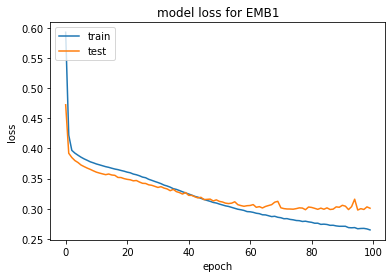

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

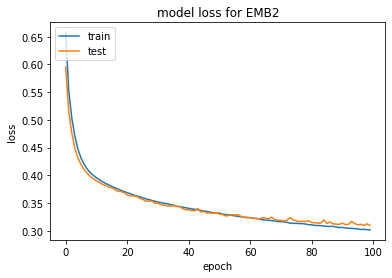

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

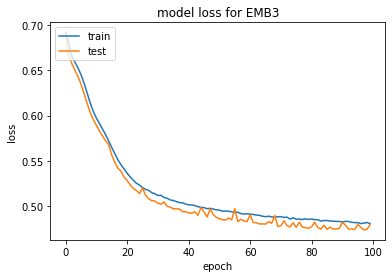

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

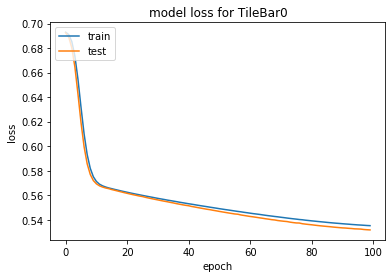

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

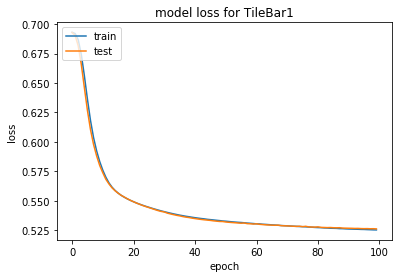

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

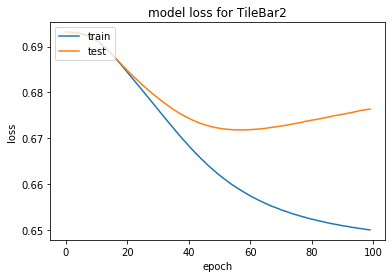

In [26]:
# Plot accuracy and loss vs. epoch

# print(history_flat[0].history)
# print(scores[0])

# list all data in history
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_flat[layer_i].history['acc'])
    plt.plot(history_flat[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_flat[layer_i].history['loss'])
    plt.plot(history_flat[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
    plt.show()

    
# plt.cla(); plt.clf()
# fig = plt.figure()
# fig.patch.set_facecolor('white')

# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# # summarize history for loss
# fig = plt.figure()
# fig.patch.set_facecolor('white')
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [27]:
from sklearn.metrics import roc_curve, auc

In [28]:
# roc curves, for all layers


y_flat_pred = {}
fpr_flat_nn = {} 
tpr_flat_nn = {} 
thres_flat_nn = {}
auc_flat_nn = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
    fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
    print("Area under curve: {}".format(auc_flat_nn[layer_i]))

Area under curve: 0.9374562609690109
Area under curve: 0.9344813618023038
Area under curve: 0.830392984017407
Area under curve: 0.7283185218349723
Area under curve: 0.7241759900592439
Area under curve: 0.6013480952404574


In [29]:
x_lc = np.append(1-p0['cluster_emProb'],1 - pp['cluster_emProb'])
y_lc = np.append(p0['label'], pp['label']) 

In [30]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

Area under curve: 0.9288563594


<Figure size 432x288 with 0 Axes>

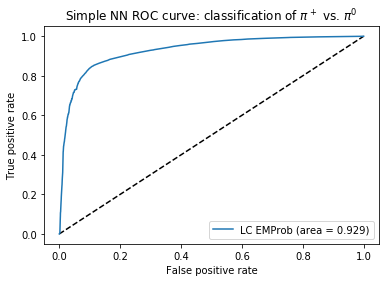

In [31]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

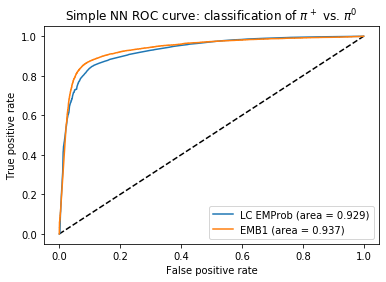

In [32]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_emb1_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

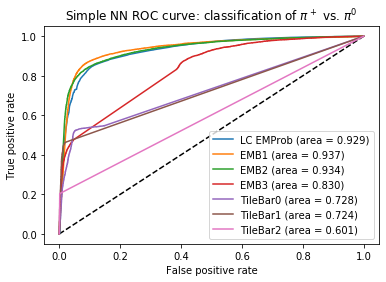

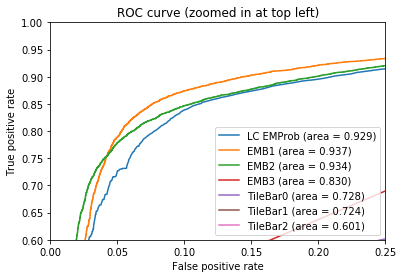

In [33]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_layers.pdf')
plt.show()


In [34]:
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))

y_flat_pred_vl = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred_vl[layer_i] = models_flat[layer_i].predict(x_flat_vl[layer_i])
#     print len(y_flat_pred_vl[layer_i])

y_flat_pred_vl_stack = np.column_stack((y_flat_pred_vl[0][:,1], y_flat_pred_vl[1][:,1],y_flat_pred_vl[2][:,1],y_flat_pred_vl[3][:,1],y_flat_pred_vl[4][:,1],y_flat_pred_vl[5][:,1]))

In [37]:
model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
history_simpleCombine = model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 120, batch_size = 200, verbose = 2)

Epoch 1/120
 - 1s - loss: 0.6855 - acc: 0.6084
Epoch 2/120
 - 0s - loss: 0.5165 - acc: 0.9000
Epoch 3/120
 - 0s - loss: 0.3105 - acc: 0.9089
Epoch 4/120
 - 0s - loss: 0.2620 - acc: 0.9102
Epoch 5/120
 - 0s - loss: 0.2526 - acc: 0.9117
Epoch 6/120
 - 0s - loss: 0.2493 - acc: 0.9126
Epoch 7/120
 - 0s - loss: 0.2473 - acc: 0.9136
Epoch 8/120
 - 0s - loss: 0.2462 - acc: 0.9130
Epoch 9/120
 - 0s - loss: 0.2454 - acc: 0.9134
Epoch 10/120
 - 0s - loss: 0.2451 - acc: 0.9137
Epoch 11/120
 - 0s - loss: 0.2446 - acc: 0.9135
Epoch 12/120
 - 0s - loss: 0.2443 - acc: 0.9136
Epoch 13/120
 - 0s - loss: 0.2442 - acc: 0.9139
Epoch 14/120
 - 0s - loss: 0.2444 - acc: 0.9137
Epoch 15/120
 - 0s - loss: 0.2440 - acc: 0.9139
Epoch 16/120
 - 0s - loss: 0.2439 - acc: 0.9140
Epoch 17/120
 - 0s - loss: 0.2437 - acc: 0.9138
Epoch 18/120
 - 0s - loss: 0.2436 - acc: 0.9139
Epoch 19/120
 - 0s - loss: 0.2437 - acc: 0.9142
Epoch 20/120
 - 0s - loss: 0.2435 - acc: 0.9143
Epoch 21/120
 - 0s - loss: 0.2437 - acc: 0.9143
E

<Figure size 432x288 with 0 Axes>

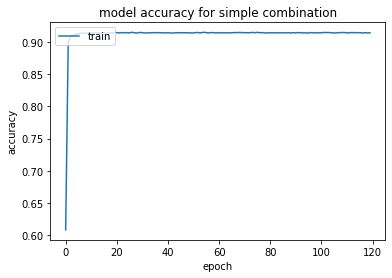

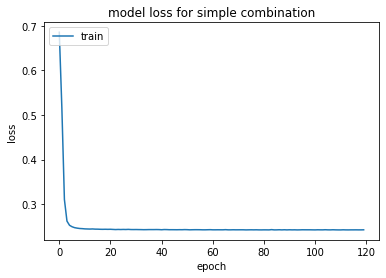

In [38]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_simpleCombine.history['acc'])
#     plt.plot(history_simpleCombine.history['val_acc'])
    plt.title('model accuracy for simple combination')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_simpleCombine.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_simpleCombine.history['loss'])
#     plt.plot(history_simpleCombine.history['val_loss'])
    plt.title('model loss for simple combination')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_simpleCombine.pdf')
    plt.show()
    

In [41]:
combined_pred = model_simpleCombine.predict(y_flat_pred_vl_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print(auc_combined)

0.963594432735393


<Figure size 432x288 with 0 Axes>

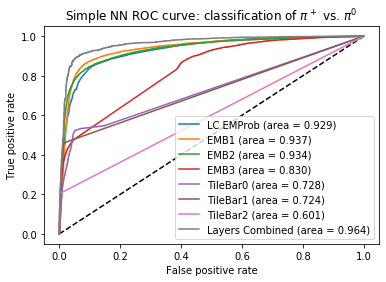

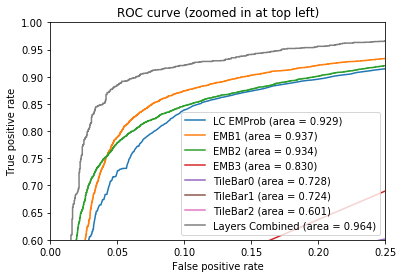

In [42]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine1_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine1_layers.pdf')
plt.show()


In [43]:

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense

In [44]:
model_combine = Sequential()

#EMB1
input1 = Input(shape=(512,), name = 'input1')
x1 = Dense(512, activation='relu')(input1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dense(128, activation='relu')(x1)

input2 = Input(shape=(256,), name = 'input2')
x2 = Dense(256, activation='relu')(input2)
x2 = Dense(128, activation='relu')(x2)
x2 = Dense(64, activation='relu')(x2)

input3 = Input(shape=(128,), name = 'input3')
x3 = Dense(128, activation='relu')(input3)
x3 = Dense(64, activation='relu')(x3)
x3 = Dense(32, activation='relu')(x3)

input4 = Input(shape=(16,), name = 'input4')
x4 = Dense(16, activation='relu')(input4)
x4 = Dense(8, activation='relu')(x4)
x4 = Dense(4, activation='relu')(x4)

input5 = Input(shape=(16,), name = 'input5')
x5 = Dense(16, activation='relu')(input5)
x5 = Dense(8, activation='relu')(x5)
x5 = Dense(4, activation='relu')(x5)

input6 = Input(shape=(8,), name = 'input6')
x6 = Dense(8, activation='relu')(input6)
x6 = Dense(4, activation='relu')(x6)
x6 = Dense(2, activation='relu')(x6)

x = concatenate([x1, x2, x3, x4, x5, x6]) 
x = Dense(100, activation='relu')(x)   

output_combine = Dense(2, activation='softmax')(x)

model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])   

In [45]:
history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=80, batch_size=200, verbose=2)

Train on 75000 samples, validate on 5000 samples
Epoch 1/80
 - 7s - loss: 0.5234 - acc: 0.8288 - val_loss: 0.3820 - val_acc: 0.8602
Epoch 2/80
 - 6s - loss: 0.3793 - acc: 0.8587 - val_loss: 0.3589 - val_acc: 0.8682
Epoch 3/80
 - 6s - loss: 0.3626 - acc: 0.8652 - val_loss: 0.3446 - val_acc: 0.8738
Epoch 4/80
 - 6s - loss: 0.3466 - acc: 0.8683 - val_loss: 0.3291 - val_acc: 0.8790
Epoch 5/80
 - 7s - loss: 0.3301 - acc: 0.8724 - val_loss: 0.3165 - val_acc: 0.8828
Epoch 6/80
 - 6s - loss: 0.3185 - acc: 0.8798 - val_loss: 0.3084 - val_acc: 0.8876
Epoch 7/80
 - 6s - loss: 0.3108 - acc: 0.8844 - val_loss: 0.3021 - val_acc: 0.8904
Epoch 8/80
 - 6s - loss: 0.3052 - acc: 0.8872 - val_loss: 0.2976 - val_acc: 0.8922
Epoch 9/80
 - 6s - loss: 0.3001 - acc: 0.8889 - val_loss: 0.2932 - val_acc: 0.8944
Epoch 10/80
 - 6s - loss: 0.2960 - acc: 0.8909 - val_loss: 0.2913 - val_acc: 0.8944
Epoch 11/80
 - 6s - loss: 0.2918 - acc: 0.8931 - val_loss: 0.2872 - val_acc: 0.8990
Epoch 12/80
 - 6s - loss: 0.2875 - a

<Figure size 432x288 with 0 Axes>

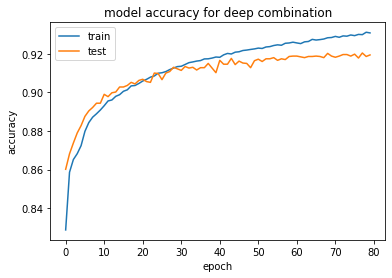

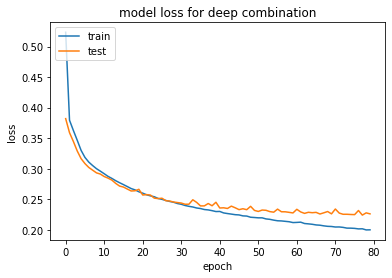

In [46]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_combine.history['acc'])
plt.plot(history_combine.history['val_acc'])
plt.title('model accuracy for deep combination')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/accuracy_deepCombine.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_combine.history['loss'])
plt.plot(history_combine.history['val_loss'])
plt.title('model loss for deep combination')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/loss_deepCombine.pdf')
plt.show()


In [47]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

Area under curve: 0.9632524283437962


<Figure size 432x288 with 0 Axes>

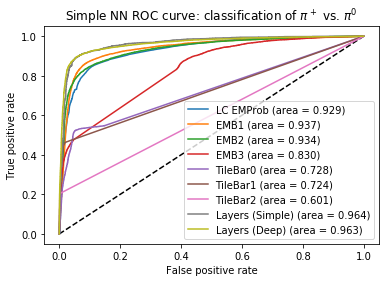

<Figure size 432x288 with 0 Axes>

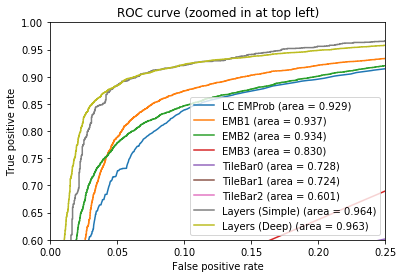

In [48]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_layers.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_layers.pdf')
plt.show()


In [74]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

<Figure size 432x288 with 0 Axes>

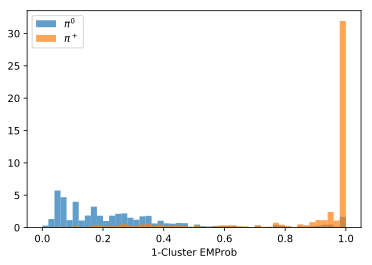

<Figure size 432x288 with 0 Axes>

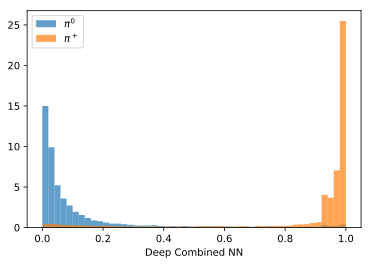

<Figure size 432x288 with 0 Axes>

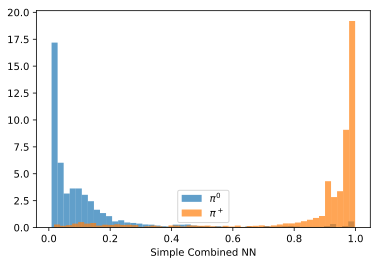

<Figure size 432x288 with 0 Axes>

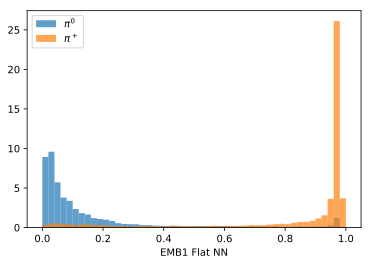

<Figure size 432x288 with 0 Axes>

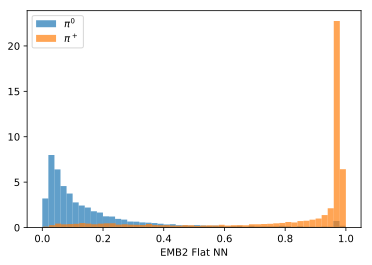

<Figure size 432x288 with 0 Axes>

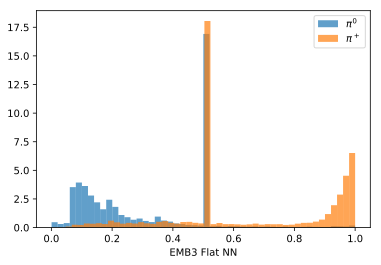

<Figure size 432x288 with 0 Axes>

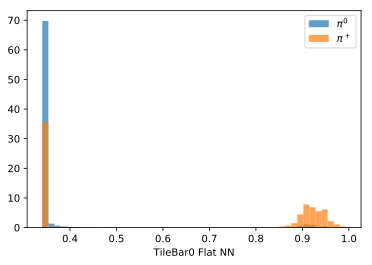

<Figure size 432x288 with 0 Axes>

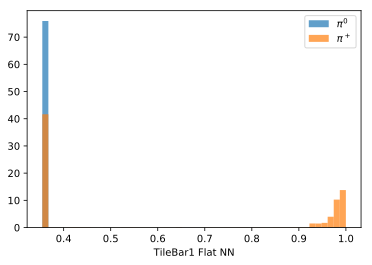

<Figure size 432x288 with 0 Axes>

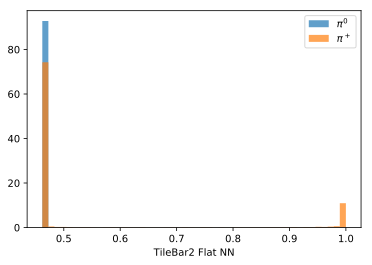

In [92]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('Plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('Plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('Plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('Plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

## 2. Convolutional Neural Network

In [132]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
    X = np.append(data_0[layer], data_1[layer], axis=0)
    X = X.reshape(X.shape[0], 1, len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)
    return X, Y, num_pixels

In [78]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(95000, 1, 16, 16)
(95000, 1)
y_train.shape:  (95000, 1)
y_train_onehot.shape:  (95000, 2)


In [133]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
# K.image_data_format('th')
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)

In [137]:
# split up into training and test datasets, using functions
test_size = 20000
validation_size = 5000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_cnn[layer_i], y_cnn[layer_i], test_size, validation_size)


y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)
y_train.shape:  (75000, 1)
y_train_onehot.shape:  (75000, 2)


In [140]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [141]:
# define a simple convolutional model

filters = [(2,4), (4,4), (4,4), (2,2), (2,2), (2,1)]

def baseline_cnn_model_layers(layer_i):
    # create model
    model = Sequential()
    model.add(Conv2D(32, filters[layer_i], input_shape=(1,len_phi[layer_i],len_eta[layer_i]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [109]:
# build the model
model_cnn_base = baseline_ccn_model()
model_cnn_base.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 6, 6)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 6, 6)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               147584    
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 258       
Total params: 148,386
Trainable params: 148,386
Non-trainable params: 0
_______________________________________________

In [142]:
model_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print(layer_name)
    print(len_phi[layer_i])
    print(len_eta[layer_i])
    model_cnn_base_layers[layer_i] = baseline_cnn_model_layers(layer_i)
    model_cnn_base_layers[layer_i].summary()

EMB1
4
128
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 32, 3, 125)        288       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 32, 1, 62)         0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 32, 1, 62)         0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 1984)              0         
_________________________________________________________________
dense_133 (Dense)            (None, 128)               254080    
_________________________________________________________________
dense_134 (Dense)            (None, 2)                 258       
Total params: 254,626
Trainable params: 254,626
Non-trainable params: 0
____________________________________

In [83]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [84]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 6, 6)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 5, 5)          2064      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 2, 2)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 2, 2)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)             

In [144]:
history_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=40, batch_size=200, verbose=2)


On layer EMB1
Train on 75000 samples, validate on 5000 samples
Epoch 1/40
 - 3s - loss: 0.5152 - acc: 0.7962 - val_loss: 0.4803 - val_acc: 0.8064
Epoch 2/40
 - 3s - loss: 0.4900 - acc: 0.8138 - val_loss: 0.4775 - val_acc: 0.8148
Epoch 3/40
 - 3s - loss: 0.4769 - acc: 0.8187 - val_loss: 0.4336 - val_acc: 0.8422
Epoch 4/40
 - 3s - loss: 0.4183 - acc: 0.8392 - val_loss: 0.3951 - val_acc: 0.8474
Epoch 5/40
 - 3s - loss: 0.4070 - acc: 0.8419 - val_loss: 0.3918 - val_acc: 0.8478
Epoch 6/40
 - 3s - loss: 0.4037 - acc: 0.8425 - val_loss: 0.3877 - val_acc: 0.8488
Epoch 7/40
 - 3s - loss: 0.3995 - acc: 0.8436 - val_loss: 0.3845 - val_acc: 0.8506
Epoch 8/40
 - 3s - loss: 0.3975 - acc: 0.8449 - val_loss: 0.3834 - val_acc: 0.8544
Epoch 9/40
 - 3s - loss: 0.3954 - acc: 0.8466 - val_loss: 0.3786 - val_acc: 0.8548
Epoch 10/40
 - 3s - loss: 0.3941 - acc: 0.8463 - val_loss: 0.3789 - val_acc: 0.8546
Epoch 11/40
 - 3s - loss: 0.3927 - acc: 0.8483 - val_loss: 0.3766 - val_acc: 0.8556
Epoch 12/40
 - 3s - lo

Epoch 17/40
 - 2s - loss: 0.5692 - acc: 0.6882 - val_loss: 0.5600 - val_acc: 0.6940
Epoch 18/40
 - 2s - loss: 0.5676 - acc: 0.6894 - val_loss: 0.5583 - val_acc: 0.6956
Epoch 19/40
 - 2s - loss: 0.5657 - acc: 0.6909 - val_loss: 0.5582 - val_acc: 0.6952
Epoch 20/40
 - 2s - loss: 0.5667 - acc: 0.6894 - val_loss: 0.5620 - val_acc: 0.6958
Epoch 21/40
 - 2s - loss: 0.5673 - acc: 0.6900 - val_loss: 0.5572 - val_acc: 0.6968
Epoch 22/40
 - 3s - loss: 0.5652 - acc: 0.6925 - val_loss: 0.5565 - val_acc: 0.7000
Epoch 23/40
 - 2s - loss: 0.5653 - acc: 0.6923 - val_loss: 0.5579 - val_acc: 0.6984
Epoch 24/40
 - 2s - loss: 0.5646 - acc: 0.6924 - val_loss: 0.5565 - val_acc: 0.6986
Epoch 25/40
 - 2s - loss: 0.5638 - acc: 0.6930 - val_loss: 0.5588 - val_acc: 0.6986
Epoch 26/40
 - 2s - loss: 0.5640 - acc: 0.6932 - val_loss: 0.5552 - val_acc: 0.6998
Epoch 27/40
 - 3s - loss: 0.5632 - acc: 0.6938 - val_loss: 0.5560 - val_acc: 0.6996
Epoch 28/40
 - 2s - loss: 0.5627 - acc: 0.6940 - val_loss: 0.5572 - val_acc:

Epoch 34/40
 - 2s - loss: 0.5305 - acc: 0.7176 - val_loss: 0.5300 - val_acc: 0.7162
Epoch 35/40
 - 2s - loss: 0.5305 - acc: 0.7178 - val_loss: 0.5305 - val_acc: 0.7154
Epoch 36/40
 - 2s - loss: 0.5308 - acc: 0.7178 - val_loss: 0.5356 - val_acc: 0.7156
Epoch 37/40
 - 2s - loss: 0.5307 - acc: 0.7177 - val_loss: 0.5302 - val_acc: 0.7166
Epoch 38/40
 - 2s - loss: 0.5308 - acc: 0.7178 - val_loss: 0.5299 - val_acc: 0.7160
Epoch 39/40
 - 2s - loss: 0.5303 - acc: 0.7180 - val_loss: 0.5298 - val_acc: 0.7156
Epoch 40/40
 - 2s - loss: 0.5304 - acc: 0.7181 - val_loss: 0.5307 - val_acc: 0.7154
On layer TileBar2
Train on 75000 samples, validate on 5000 samples
Epoch 1/40
 - 3s - loss: 0.6797 - acc: 0.5344 - val_loss: 0.6661 - val_acc: 0.5594
Epoch 2/40
 - 2s - loss: 0.6621 - acc: 0.5557 - val_loss: 0.6583 - val_acc: 0.5036
Epoch 3/40
 - 2s - loss: 0.6580 - acc: 0.5622 - val_loss: 0.6543 - val_acc: 0.5774
Epoch 4/40
 - 3s - loss: 0.6560 - acc: 0.5657 - val_loss: 0.6601 - val_acc: 0.5036
Epoch 5/40
 -

<Figure size 432x288 with 0 Axes>

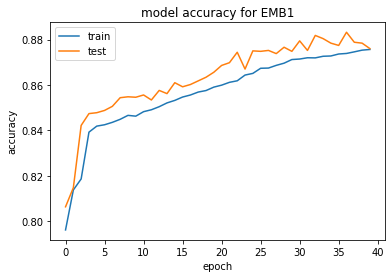

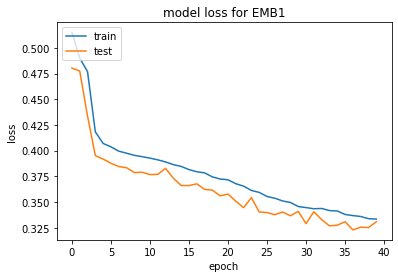

<Figure size 432x288 with 0 Axes>

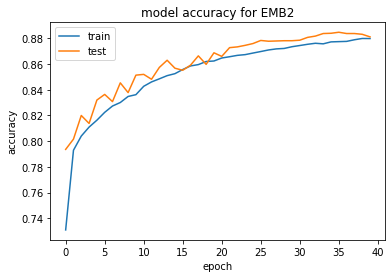

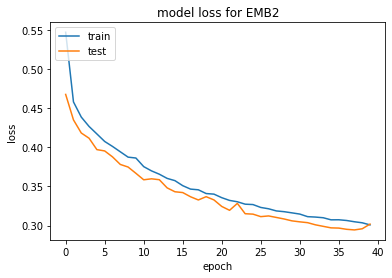

<Figure size 432x288 with 0 Axes>

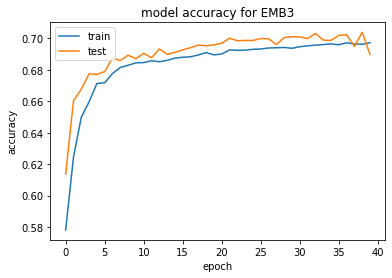

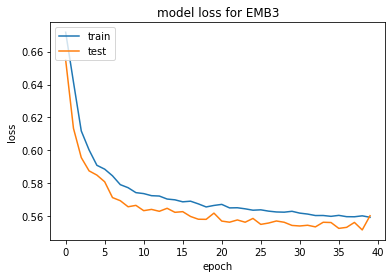

<Figure size 432x288 with 0 Axes>

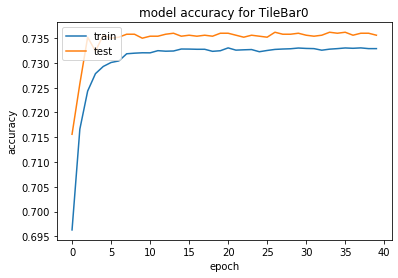

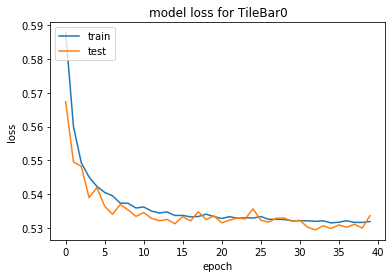

<Figure size 432x288 with 0 Axes>

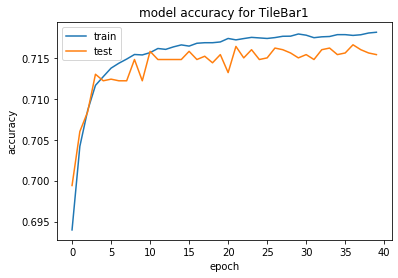

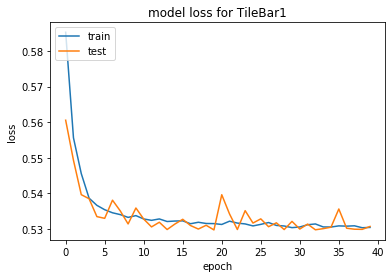

<Figure size 432x288 with 0 Axes>

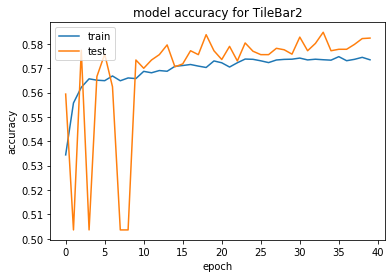

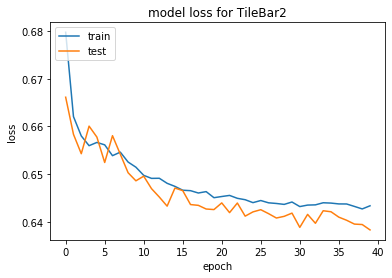

In [145]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_base_layers[layer_i].history['acc'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_cnn_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_base_layers[layer_i].history['loss'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_cnn_{}.pdf'.format(layer_name))
    plt.show()

In [86]:
# fit (train) the baseline cnn model
history_cnn_base = model_cnn_base.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_base = model_cnn_base.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_base[1]*100))

Train on 95000 samples, validate on 1000 samples
Epoch 1/40
 - 3s - loss: 0.3202 - accuracy: 0.8712 - val_loss: 0.2966 - val_accuracy: 0.8840
Epoch 2/40
 - 3s - loss: 0.3167 - accuracy: 0.8729 - val_loss: 0.2967 - val_accuracy: 0.8790
Epoch 3/40
 - 3s - loss: 0.3165 - accuracy: 0.8734 - val_loss: 0.2954 - val_accuracy: 0.8800
Epoch 4/40
 - 3s - loss: 0.3142 - accuracy: 0.8735 - val_loss: 0.2888 - val_accuracy: 0.8870
Epoch 5/40
 - 3s - loss: 0.3128 - accuracy: 0.8747 - val_loss: 0.2981 - val_accuracy: 0.8790
Epoch 6/40
 - 3s - loss: 0.3096 - accuracy: 0.8763 - val_loss: 0.2831 - val_accuracy: 0.8830
Epoch 7/40
 - 3s - loss: 0.3094 - accuracy: 0.8762 - val_loss: 0.2870 - val_accuracy: 0.8880
Epoch 8/40
 - 3s - loss: 0.3074 - accuracy: 0.8783 - val_loss: 0.2820 - val_accuracy: 0.8850
Epoch 9/40
 - 3s - loss: 0.3058 - accuracy: 0.8782 - val_loss: 0.2819 - val_accuracy: 0.8820
Epoch 10/40
 - 3s - loss: 0.3051 - accuracy: 0.8779 - val_loss: 0.2851 - val_accuracy: 0.8810
Epoch 11/40
 - 3s - 

In [89]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

Train on 95000 samples, validate on 1000 samples
Epoch 1/40
 - 4s - loss: 0.3903 - accuracy: 0.8342 - val_loss: 0.3721 - val_accuracy: 0.8350
Epoch 2/40
 - 4s - loss: 0.3795 - accuracy: 0.8409 - val_loss: 0.3659 - val_accuracy: 0.8410
Epoch 3/40
 - 4s - loss: 0.3722 - accuracy: 0.8450 - val_loss: 0.3510 - val_accuracy: 0.8450
Epoch 4/40
 - 4s - loss: 0.3658 - accuracy: 0.8493 - val_loss: 0.3433 - val_accuracy: 0.8570
Epoch 5/40
 - 4s - loss: 0.3605 - accuracy: 0.8518 - val_loss: 0.3316 - val_accuracy: 0.8650
Epoch 6/40
 - 4s - loss: 0.3554 - accuracy: 0.8547 - val_loss: 0.3519 - val_accuracy: 0.8610
Epoch 7/40
 - 4s - loss: 0.3498 - accuracy: 0.8566 - val_loss: 0.3289 - val_accuracy: 0.8680
Epoch 8/40
 - 4s - loss: 0.3460 - accuracy: 0.8589 - val_loss: 0.3266 - val_accuracy: 0.8680
Epoch 9/40
 - 4s - loss: 0.3442 - accuracy: 0.8607 - val_loss: 0.3234 - val_accuracy: 0.8690
Epoch 10/40
 - 4s - loss: 0.3394 - accuracy: 0.8616 - val_loss: 0.3170 - val_accuracy: 0.8620
Epoch 11/40
 - 4s - 

In [90]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


KeyError: 'acc'

<Figure size 432x288 with 0 Axes>

In [93]:
y_baseline_pred = model_cnn_base.predict(X_te)
fpr_baseline, tpr_baseline, thres_baseline = roc_curve(y_te_onehot[:,1], y_baseline_pred[:,1])
auc_baseline = auc(fpr_baseline, tpr_baseline)
print("Area under curve: {}".format(auc_baseline))

y_large_pred = model_cnn_large.predict(X_te)
fpr_large, tpr_large, thres_large = roc_curve(y_te_onehot[:,1], y_large_pred[:,1])
auc_large = auc(fpr_large, tpr_large)
print("Area under curve: {}".format(auc_large))

Area under curve: 0.9482839437465216
Area under curve: 0.9426352090745941


In [148]:
y_baseline_layers_pred = {}
fpr_baseline_layers = {}
tpr_baseline_layers = {}
thres_baseline_layers = {}
auc_baseline_layers = {}
for layer_i, layer_name in enumerate(layers):
    y_baseline_layers_pred[layer_i] = model_cnn_base_layers[layer_i].predict(x_cnn_te[layer_i])
    fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], thres_baseline_layers[layer_i] = roc_curve(y_cnn_te_onehot[layer_i][:,1], y_baseline_layers_pred[layer_i][:,1])
    auc_baseline_layers[layer_i] = auc(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i])
    print("Area under curve: {}".format(auc_baseline_layers[layer_i]))
#     y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
#     fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
#     auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
#     print("Area under curve: {}".format(auc_flat_nn[layer_i]))


Area under curve: 0.9253611162804765
Area under curve: 0.9417784142986617
Area under curve: 0.7428391300542257
Area under curve: 0.7297380726607765
Area under curve: 0.7190348362505088
Area under curve: 0.5845779747061488


<Figure size 432x288 with 0 Axes>

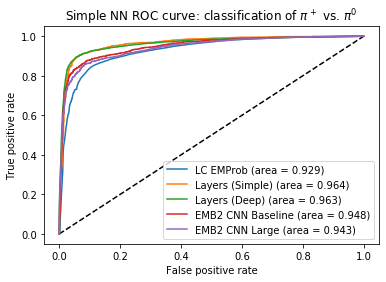

<Figure size 432x288 with 0 Axes>

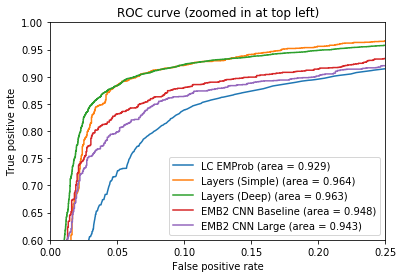

In [94]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_cnn.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

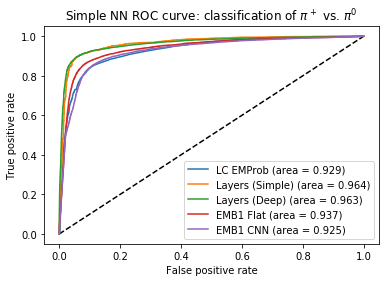

<Figure size 432x288 with 0 Axes>

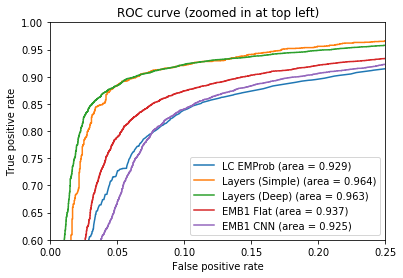

<Figure size 432x288 with 0 Axes>

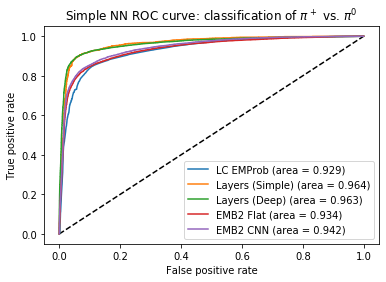

<Figure size 432x288 with 0 Axes>

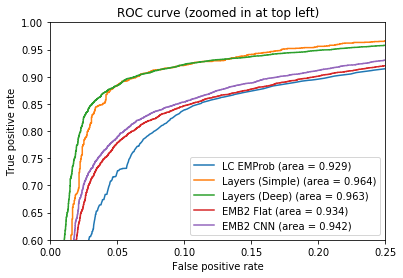

<Figure size 432x288 with 0 Axes>

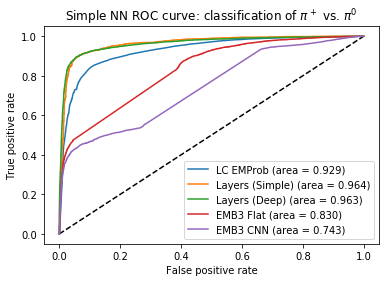

<Figure size 432x288 with 0 Axes>

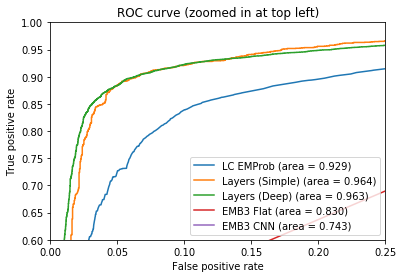

<Figure size 432x288 with 0 Axes>

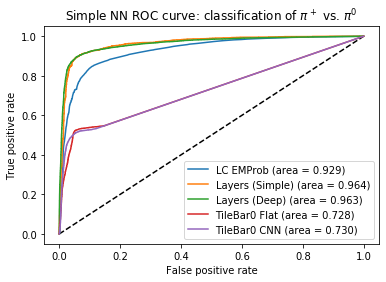

<Figure size 432x288 with 0 Axes>

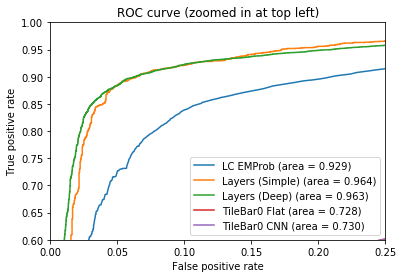

<Figure size 432x288 with 0 Axes>

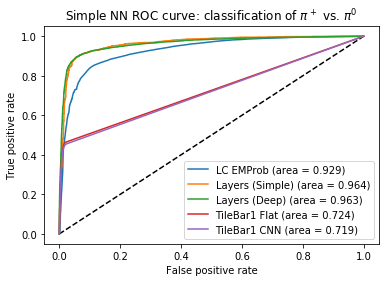

<Figure size 432x288 with 0 Axes>

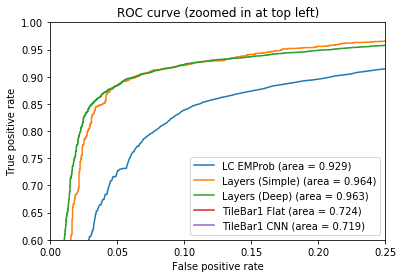

<Figure size 432x288 with 0 Axes>

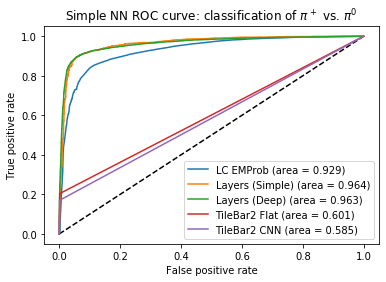

<Figure size 432x288 with 0 Axes>

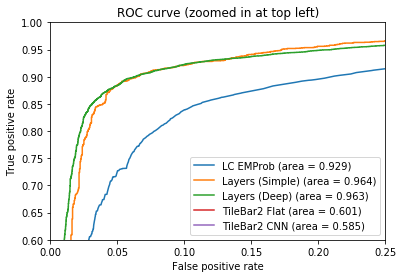

In [155]:
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()


    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    # Zoom in view of the upper left corner.
    plt.xlim(0, 0.25)
    plt.ylim(0.6, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    # ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_zoom_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print X0.shape
print X1.shape
print X2.shape
print y.shape

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [ ]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

In [ ]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [ ]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

In [ ]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')